# 第五章 在无标签数据集上预训练

## 5.1 评估文本生成大模型
### 5.1.1 用GPT来生成文本

In [1]:
import torch
from previous_chapters import *
import torch.nn.functional as F
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference
#导入模型, 设定一系列参数, 设定随机种子确保可复现

In [2]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    token_ids = token_ids.squeeze(0)  # Remove batch dimension
    decoded = tokenizer.decode(token_ids.tolist())
    return decoded


start_context = 'every effort moves you'
tokenizer = tiktoken.get_encoding("gpt2")
# 举例说明

token_ids = generate_text_simple(model=model,idx=text_to_token_ids(start_context, tokenizer), max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])

print("output text:\n",token_ids_to_text(token_ids, tokenizer))


output text:
 every effort moves you rentingetic minion mobilized Macicone heterogeneity achaRAM


### 5.1.2&3 计算训练集和验证集的损失

In [20]:
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text_data = f.read()
# 检查数据集中的字符数和词元数
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Total characters:", total_characters)
print("Total tokens:", total_tokens)
print("Sample text:\n", text_data[:50])  # Print the first 500 characters
text_data[:50]
tokenizer.encode(text_data)[:50]

Total characters: 20479
Total tokens: 5145
Sample text:
 I HAD always thought Jack Gisburn rather a cheap g


[40,
 367,
 2885,
 1464,
 1807,
 3619,
 402,
 271,
 10899,
 2138,
 257,
 7026,
 15632,
 438,
 2016,
 257,
 922,
 5891,
 1576,
 438,
 568,
 340,
 373,
 645,
 1049,
 5975,
 284,
 502,
 284,
 3285,
 326,
 11,
 287,
 262,
 6001,
 286,
 465,
 13476,
 11,
 339,
 550,
 5710,
 465,
 12036,
 11,
 6405,
 257,
 5527,
 27075,
 11]

In [4]:
train_ratio = 0.9
split_idx = int(total_characters * train_ratio)
train_data = text_data[:split_idx]
test_data = text_data[split_idx:]

### 建立数据加载器

In [5]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data,2,max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=2)
test_loader = create_dataloader_v1(test_data,2,max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=2)
                                                                        

In [6]:
# 测试数据加载器
print("Train loader:")
for x , y in train_loader:
    print(x.shape,y.shape)


print("\nTest loader:")
for x , y in test_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Test loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [7]:
import torch
print("PyTorch 版本:", torch.__version__)
print("CUDA 可用:", torch.cuda.is_available())
print("CUDA 版本:", torch.version.cuda)
import torch
print(torch.cuda.get_device_capability())  # 输出例如(7, 5)
print(torch.cuda.get_device_name())        # 输出GPU型号

PyTorch 版本: 2.8.0+cu126
CUDA 可用: True
CUDA 版本: 12.6
(6, 1)
Tesla P40


#### 实现工具函数，计算批次的损失值

In [8]:
def calc_loss_batch(inputs,targets,model,device):
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    loss = F.cross_entropy(outputs.flatten(0,1), targets.flatten())
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches,len(data_loader))
    for i , (inputs, targets) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(inputs, targets, model, device)
        total_loss += loss.item()
    return total_loss / num_batches


### 计算损失值

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    test_loss = calc_loss_loader(test_loader, model, device)
print('Training loss:',train_loss)
print('Test loss:',test_loss)

Training loss: 10.987583372328016
Test loss: 10.98110580444336


## 5.2 训练大语言模型

In [10]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    #评价模块
    model.eval()
    #检验模式
    with torch.no_grad():
        #我认为的双保险,防止梯度更新
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    #	在评估结束后切换回训练模式，确保模型能继续用于训练。
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [11]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
    train_losses , val_losses , track_tokens_seen = [],[],[]
    tokens_seen , global_step = 0,-1
    for epoch in range(num_epochs):
        model.train()
        for input_batch , target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen +=input_batch.numel()
            global_step +=1
            
            if global_step % eval_freq ==0:
                train_loss , val_loss = evaluate_model(model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f'Ep{epoch+1} (Step{global_step:06d}):'
                      f'Train loss {train_loss:.3f},'
                      f' Val loss {val_loss:.3f},')
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses , val_losses , track_tokens_seen


In [14]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004,weight_decay=0.1)
num_epochs = 10
train_losses , val_losses , tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context='Every effort moves you',
    tokenizer=tokenizer
)

Ep1 (Step000000):Train loss 9.819, Val loss 9.926,
Ep1 (Step000005):Train loss 7.921, Val loss 8.340,
Every effort moves you,,,,,,,,,,,,.                                     
Ep2 (Step000010):Train loss 6.585, Val loss 7.046,
Ep2 (Step000015):Train loss 5.979, Val loss 6.593,
Every effort moves you, the, the, the, the, the, the. ", the, the,,, the, and, the, of the, the, the,, the, the,, the, the, the, and, the
Ep3 (Step000020):Train loss 5.608, Val loss 6.403,
Ep3 (Step000025):Train loss 4.802, Val loss 6.414,
Every effort moves you know the picture.  "I was his the picture the picture. "I was--I--and it. "I had the picture--and it was his my the picture--and the picture and I had been I had been
Ep4 (Step000030):Train loss 4.273, Val loss 6.228,
Ep4 (Step000035):Train loss 3.833, Val loss 6.225,
Every effort moves you know of the fact of the of his pictures--I had been.  "I was not to me to have to have to have of the of his pictures--I had been the picture.     "I he was his
Ep5 (St

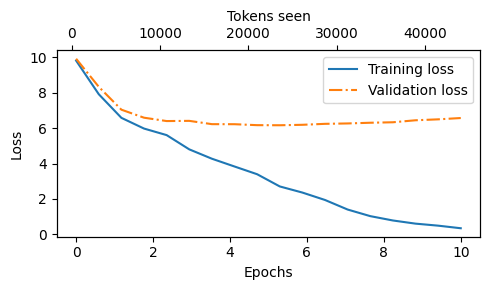

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#一个经典的plot画图函数

## 5.3 控制随机性的解码策略
## 通过温度缩放和Top-k采样策略修改文本生成函数

In [21]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]  # Crop context if needed
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val,torch.tensor(float('-inf')).to(logits.device),logits) 
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx =  torch.cat((idx, idx_next), dim=1)
    return idx

In [23]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
#经典的操作

Output text:
 Every effort moves you?"
It his furrow too? I haven't let by his last


# 5.4 保存模型权重

In [ ]:
torch.save(model.state_dict(), "model.pth")


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth",map_location=device))
model.eval()

In [26]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "model_and_optimizer.pth")

In [27]:
checkpoint = torch.load("model_and_optimizer.pth",map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004,weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features